# Mask R-CNN Training and Inference on a Novel Dataset of Aerial Slum Images
This notebook utilizes Matterport's implementation of Mask RCNN with significant amendments done both manually and through cloning akTwelve's forked version of the Matterport GitHub repository. The key dataset comes from an aerial image taken from Google Satellite, processed in a separate pipeline.

#### Purpose

The purpose of this project is to eventually create a robust instance segmentation model which is able to effectively segment individual slum units from aerial imagery. This provides extremely rich data on an otherwise underserved part of the global population. Given a robust model, the insights we can gather could be from calculating the rate of increase of slum unit area and numbers over a period of time (because satellite data is historical as well). The collection of a unit which measures the rate at which slums grow, or the propensity with which slums are expected to grow, can be highly useful in both causal and predictive inference problems, especially if paired with ground-truth census data. On the flip-side, one can also expect to see declines in slum area and instances over time in certain countries, either due to sustainable slum development and rehabilitation approaches, or due to forcible slum removal and destruction. The hope is that this model provides a useful starting point for gathering the key descriptive statistics necessary for making high quality evidence-based hypotheses for slum growth and persistence in Pakistan.

To that end, the sole satellite image used to drive the dataset is from the author's hometown of Islamabad, Pakistan, which hosts a large slum called the "Christian Colony" in the middle of a high-income area.

### Dependency Resolution

Abdulla (2017) implemented the landmark architecture introduced by He et al. (2017) - Mask R-CNN - with several improvements, the details of which can be found by following the relevant link in the references. The Matterport repository ran into several dependency issues over the years, requiring major edits of the code. We use the forked Matterport repository (akTwelve, n.d.) to resolve some of these dependency issues, while others were resolved through community-driven solutions (see Appendix for more detail). The notebook structure is borrowed from the train_shapes.ipynb from the same repository.

The magic syntax pip uninstall commands provided in the following code cell were necessary to downgrade certain package versions whilst troubleshooting the dependency issues. These are left in to indicate likely points of failure for future replications of this notebook. An example of a dependency issue which required downgrading was tensorflow 2.4.1 requiring numpy~=1.19.2 and h5py~=2.10.0, which led to a circular dependency with scikit-image requiring versions of numpy outside the domain. This was resolved by downgrading tensorflow to 2.3.1. Based on trends in community blogposts (Appendix), downgrading to tensorflow 1.X seemed to be a blanket solution for a wide range of bugs.

### Installing and Importing Packages 

In [63]:
# %pip install --upgrade pip
# %pip install numpy==1.23.2
# %pip install h5py==2.10.0
# %pip install scipy==1.5.4
# %pip install scikit-image==0.17.2
# %pip install matplotlib==3.3.0 
# %pip install path to wheel file
# %pip install tensorflow==2.3.1
# %pip install scikit-image==0.16.2
# %pip install keras==2.4.3
# %pip install imgaug
# %pip install IPython

# %pip uninstall numpy --yes
# %pip uninstall scipy --yes
# %pip uninstall scikit-image --yes
# %pip uninstall matplotlib --yes
# %pip uninstall tensorflow --yes
# %pip uninstall scikit-image --yes
# %pip uninstall mrcnn --yes
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw


### Cloning the Repository

The repository is cloned using a shell command. Other attempts at cloning the Mask_RCNN project from forked versions are commented out. The tomgross and leekunhee repositories patched unique, sometimes overlapping, but non-exhaustive segments of the bugged model.py file, key in using the mrcnn package.

In [65]:
!git clone https://github.com/akTwelve/Mask_RCNN.git
#!git clone https://github.com/matterport/Mask_RCNN
#!git clone https://github.com/tomgross/Mask_RCNN.git
#!git clone https://github.com/leekunhee/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


#### Setting the Root Directory

The root directory is set to the author's local device allowing for usage of the mrcnn package cloned from the akTwelve GitHub repository.

In [66]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo

ROOT_DIR = 'c:/Users/raphael khalid/Desktop/Slums/November Capstone/Mask_RCNN/'

# To avoid numpy version errors with tensorflow
np.object = object
np.bool = bool
np.int = int
np.float = float
np.typeDict = np.sctypeDict

sys.path.append(ROOT_DIR) 
sys.path.append(os.path.join(ROOT_DIR, 'mrcnn'))

# Import mrcnn libraries
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib


## Model Logging and Pre-trained Model Weights

The next code cell sets up the directories to save the logs of the model and the weights of the Mask R-CNN trained on the MSCOCO dataset, provided by Abdullah (2017). The model weights are downloaded if not already available.

In [67]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights if not already there
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configuration

The following code cell is a slightly modified version of the code given by Abdulla (2017). Five variables defined in the code cell below are explained in detail in this section, to the end of better code-readability and understanding of the hyperparameters for finetuning the model.

* RPN_ANCHOR_SCALES: These are the lengths of the sides of square anchors used in the Region Proposal Network (RPN) to propose potential object locations in the image. These scales, measured in pixels, determine the range of anchor sizes.

* TRAIN_ROIS_PER_IMAGE: This variable defines the number of Region of Interest (ROI) proposals per image that are fed to the classifier and mask heads during training. He et al. (2017) used 512 ROIs, but this may lead to an insufficient number of positive proposals from the Region Proposal Network (RPN). 

* MAX_GT_INSTANCES: Specifies the maximum number of ground truth instances (objects) to be used in a single training image. This parameter controls the upper limit on the number of annotated instances during training. The most instances in one image in the dataset is 65, so it is reasonable to set the upper limit to 100. This number ought to increase to 1000 in future implementations of this notebook, to match the reasoning provided by Waqas Zamir et al. (2019), i.e., "Since, large number of objects are present
per image...."

* POST_NMS_ROIS_INFERENCE: This parameter determines the number of Region of Interest (ROI) proposals to keep after non-maximum suppression (NMS) during inference (model prediction). It restricts the number of proposed regions to avoid redundancy and select the most confident ones. In this case, 500 ROIs are kept after NMS during inference (Abdulla, 2017).

* POST_NMS_ROIS_TRAINING: Similar to POST_NMS_ROIS_INFERENCE, but this parameter is applied during the training phase. It controls the number of ROIs to keep after non-maximum suppression in training. A higher value during training allows more proposals to be considered, potentially improving the model's ability to learn from a diverse set of ROIs during the training process (Abdulla, 2017).

In [68]:
class SlumConfig(Config):
    """
    Configuration for training a model on the slums dataset.
    Extends the base Config class and customizes values specific
    to the slums dataset.
    """
    NAME = "slums"

    # Set to 1 because we are using a CPU
    GPU_COUNT = 1

    # Code author suggests that a 12GB GPU can handle 2 images of 1024x1024px, so we will use that as a baseline.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  

    # The dimension constraints dictate a min and max image dimension number which is divisable by 2 at least 6 times
    # because of the downsampling done in the neural network (2^6 = 64).
    
    # Input image resizing
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Number of training steps per epoch, not contingent on training dataset size
    STEPS_PER_EPOCH = 50

    # Number of validation steps to run after every epoch, setting too large slows down training
    VALIDATION_STEPS = 5
    
    # Backbone network architecture, can be resnet50 or resnet101, Waqas Zamir et al. used ResNet152-FPN to create PANet++
    BACKBONE = 'resnet101'

    # Explained in-text above
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 100 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = SlumConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

#### Converting COCO-like Json to Instance Segmentation Masks
The following code cell is used as-is from Abdulla et al. (2017). This step is essential as the instance segmentation task requires a pixel-level segmentation of classes. The COCO-like JSON file only contains the information pertaining to the polygons bounding the instances. The following code cell uses ImageDraw to create masks from the polygons' vertices, and encode them as boolean arrays, denoting whether or not a pixel belongs to a class, in addition to the class_ids which in this case is just 1 (for slums). The CocoLikeDataset class allows us to process our training and validation data into a format which Mask R-CNN can use. 

In [69]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [70]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('C:/Users/raphael khalid/Desktop/Slums/November Capstone/dataset/coco_json/christian_colony_annotations_training.json',
                         'C:/Users/raphael khalid/Desktop/Slums/November Capstone/dataset/training')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('C:/Users/raphael khalid/Desktop/Slums/November Capstone/dataset/coco_json/christian_colony_annotations_validation.json',
                       'C:/Users/raphael khalid/Desktop/Slums/November Capstone/dataset/validation')
dataset_val.prepare()

#### Satellite Image Pipeline Summary

The dataset was created using a single 10087x8665 Google Satellite image of the so-called "Christian Colony" slum in F-6, Islamabad, Pakistan. QGIS was used to export the GeoTiff file of the region of interest, and rasterio was used to convert this file into six 800x800 .jpg files using a tiling method. 800x800 was used as that was the minimum image size in the iSAID dataset (Waqas Zamir et al., 2019). The next iteration of this project will incorporate that dataset in conjunction with the slum data, which is why maintaining a similar minimum image size is important.

#### Dataset Overview
There are 6 images in the dataset, with 196 instances of slums across all images. 4 images are split into the training dataset and 2 are split into the validation data set. The images were manually annotated using MakeSense.ai. Relying on the wisdom of Waqas Zamir et al. (2019), who themselves stood on the shoulders of giants (Xia et al., 2018; Lam et al., 2018; Zhou et al., 2017; Lin et al., 2014; Everingham et al., 2010), the following annotation guidelines were used:

1) All clearly visible objects category "slum" must be annotated;
2) Segmentation masks for each instance should match its visual margin in the image;
3) Images should be zoomed in or out, when necessary, to obtain annotations with refined boundaries; 

#### Missing Annotations
Kaliuzhnyi et al. (2023) find that modern object detection algorithms could require just 10% of instances in an image to be annotated to achieve results near-equal to those images with 50% of instances classified. This was used in guiding an emphasis of accuracy over quantity of annotations. The satellite data obtained is difficult to visually process given the constraint of its resolution, coming from a pipeline reliant on free and open-source software. This, in addition to the crowdedness of slums units, makes differentiating between individual slum units quite difficult, as there is infrequent but consistent sharing of the same roofs between different units. Shadows, edges of buildings, and color or texture changes between roofs were all useful indicators for annotating the images.

#### Visualizing the Dataset
The code cell below visualizes the aerial images of the slums, in addition to their instance segmentation maps. Note that each instance has a different color, though due to the high volume of instances per image, the unique colours appear more as a gradient.

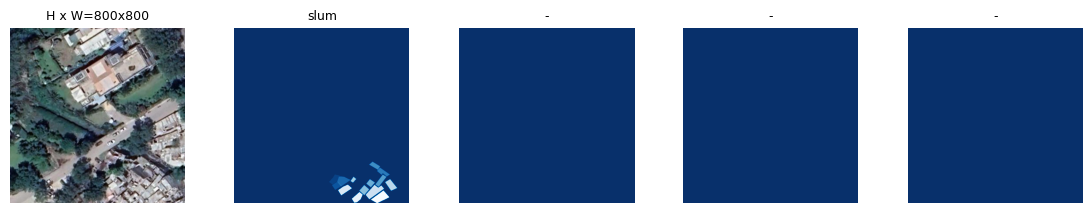

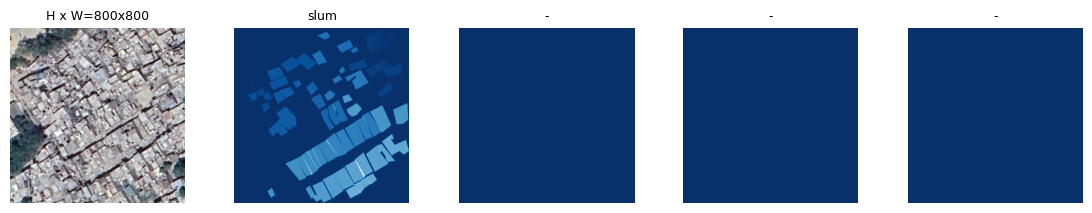

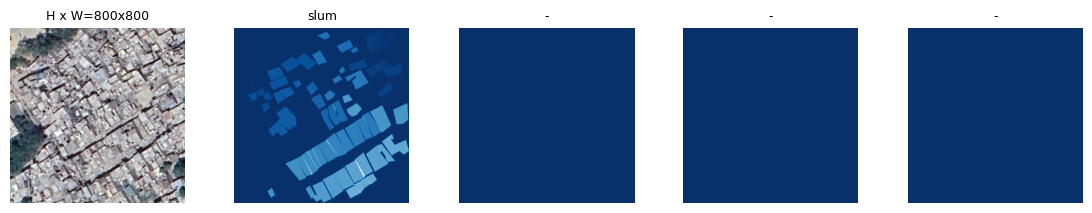

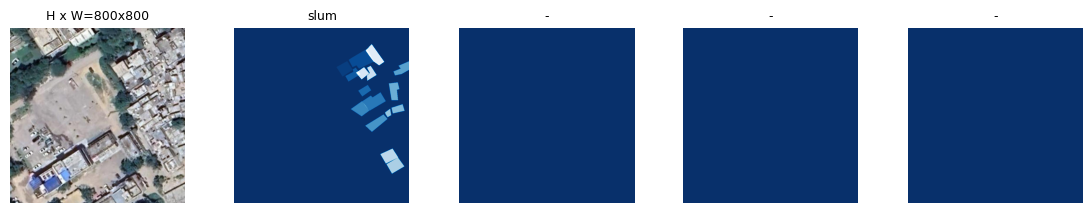

In [71]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Model Training

We initialize the model with the weights from the aforementioned pre-trained model, allowing options for imagenet or the last best weights to allow for easy comparisons between different models. This comparison is reserved for a future iteration of this project. The model is trained for four epochs and only the head layer weights are updated, keeping the backbone layer weights frozen, a standard technique when applying transfer learning. We would change the argument layers = 'heads' to 'all' if we wanted to further finetune the model.

In [72]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [73]:
init_with = "coco"  

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)

elif init_with == "coco":

    # skip layers with inconsistent class names
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [74]:
# Training code cell: head layers only

import warnings
warnings.filterwarnings('ignore')

start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: c:/Users/raphael khalid/Desktop/Slums/November Capstone/Mask_RCNN/logs\slums20231110T0332\mask_rcnn_slums_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc       

# Model Inference
#### Setup

In [75]:
class InferenceConfig(SlumConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Minimum probability of an ROI to accept a detected instance, baseline is 0.5 (50%) based on Mask RCNN paper
    DETECTION_MIN_CONFIDENCE = 0.5
    

inference_config = InferenceConfig()

In [76]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [77]:
# Get path to saved weights

# Either set a specific path or find last trained weights
#model_path = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
model_path = model.find_last() #exclude=[ "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True,exclude=[ "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

Loading weights from  c:/Users/raphael khalid/Desktop/Slums/November Capstone/Mask_RCNN/logs\slums20231110T0332\mask_rcnn_slums_0004.h5
Re-starting from epoch 4


# Results

Here we run the trained model on the validation images to evaluate the performance of the model. Ideally, we would have a testing dataset but due to size of the dataset, it is an appropriate compromise to forgo the testing dataset whilst keeping in mind that inference is being done on the validation dataset, and not a dedicated testing dataset. The downside is that the validation dataset is technically "seen" by the model during training to prevent overfitting and tune parameters, which undermines claims about model generalizability. 

Processing 1 images
image                    shape: (800, 800, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


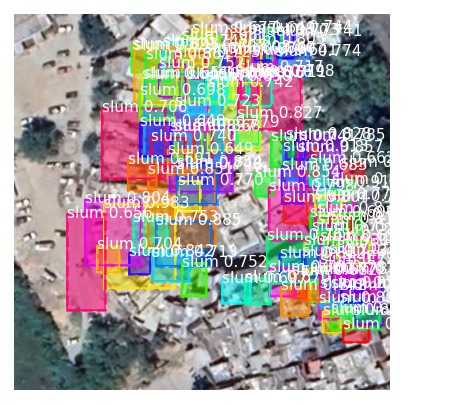

Processing 1 images
image                    shape: (800, 800, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


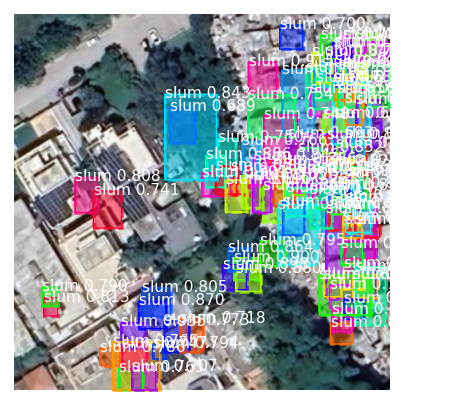

In [78]:
import skimage
real_test_dir = 'dataset/validation'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))

In [79]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
APs = []
inference_config.USE_MINI_MASK = False
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_train, inference_config, image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.00014792899422060986


We can see that the results of the instance segmentation leave a great deal to be desired. The mAP is negligbly low on the validation set; as a benchmark, we can consider the performance of PANet++ which achieved an AP of 40.00, trained on the iSAID dataset (Waqas Zamir et al., 2019) consisting of 655,451 instances being labeled for the training dataset. The main constraint in this iteration of the project was computational resources: four epochs with 50 steps each took 70.96 minutes, or around 20s per step. Scaling this up to a industry-standard level would look like 50 epochs with 1000 steps each, translating to around 277 hours of run time on this author's device: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, 1800 Mhz, 4 Core(s), 8 Logical Processor(s). 

We can see that there are many false positives (parts of the solar panels being classified as slums) as well as missed segmentations. The loss of the model appears to be decreasing consistently and there is good reason to believe to that the loss will continue to decrease for several more epochs. The most concerning flaw, however, is that there appears to be some systematic bias preferring axis aligned bounding boxes and instance masks. This may be an artefact of the RPN_ANCHOR_SCALES parameter and requires further investigation to determine whether this is an architectural flaw, or a model performance flaw.

##### Training Output Log
Epoch 1/4
50/50 [==============================] - 999s 20s/step - batch: 24.5000 - size: 1.0000 - loss: 2.4356 - rpn_class_loss: 0.1179 - rpn_bbox_loss: 0.6861 - mrcnn_class_loss: 0.5186 - mrcnn_bbox_loss: 0.6482 - mrcnn_mask_loss: 0.4647 - val_loss: 2.5837 - val_rpn_class_loss: 0.0624 - val_rpn_bbox_loss: 0.8341 - val_mrcnn_class_loss: 0.6073 - val_mrcnn_bbox_loss: 0.5934 - val_mrcnn_mask_loss: 0.4865
Epoch 2/4
50/50 [==============================] - 836s 17s/step - batch: 24.5000 - size: 1.0000 - loss: 1.3051 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.3579 - mrcnn_class_loss: 0.2973 - mrcnn_bbox_loss: 0.2859 - mrcnn_mask_loss: 0.3297 - val_loss: 2.8338 - val_rpn_class_loss: 0.0594 - val_rpn_bbox_loss: 0.9087 - val_mrcnn_class_loss: 0.6700 - val_mrcnn_bbox_loss: 0.6862 - val_mrcnn_mask_loss: 0.5094
Epoch 3/4
50/50 [==============================] - 915s 18s/step - batch: 24.5000 - size: 1.0000 - loss: 0.9647 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.2291 - mrcnn_class_loss: 0.2268 - mrcnn_bbox_loss: 0.2016 - mrcnn_mask_loss: 0.2760 - val_loss: 2.8447 - val_rpn_class_loss: 0.0707 - val_rpn_bbox_loss: 0.8728 - val_mrcnn_class_loss: 0.8939 - val_mrcnn_bbox_loss: 0.5647 - val_mrcnn_mask_loss: 0.4426
Epoch 4/4
50/50 [==============================] - 1334s 27s/step - batch: 24.5000 - size: 1.0000 - loss: 0.7426 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.1633 - mrcnn_class_loss: 0.1567 - mrcnn_bbox_loss: 0.1550 - mrcnn_mask_loss: 0.2437 - val_loss: 3.2052 - val_rpn_class_loss: 0.0874 - val_rpn_bbox_loss: 0.9202 - val_mrcnn_class_loss: 1.1480 - val_mrcnn_bbox_loss: 0.5564 - val_mrcnn_mask_loss: 0.4933
Training took 70.96 minutes

# Next Steps

* (continuous) Increase the size of the dataset. This includes annotating more aerial images of slums, with the intention being to get aerial images of the 8 world's largest slums. This would improve the regional diversity of the dataset as well, reflecting the variation in aerial slum appearance across parts of the world. The second way to increase the size of the dataset will be data augmentations. Special care will be given to ensure that the annotations are adjusted/omitted according to the given transformations.

* GPU Training: Training using Kaggle's GPU is the part of the next iteration of this project. This will allow for significant speed up of training and subsequently opens up more options for model tuning.

* Finetune the hyperparameters given GPU access: this looks like increasing the number of epochs to 50 with 1000 steps, increasing the RPN_ANCHOR_SCALES, TRAIN_ROIS_PER_IMAGE, and MAX_GT_INSTANCES parameters to industry-standard, as given by Mask R-CNN in Abdulla (2017).

* Unfreeze the backbone layers and finetune the model. Change the backbone to ResNet-152, as was the case in PANet++.

* Merge the slum dataset with the iSAID dataset which contains 15 classes of 655,451 instances, and train PANet++ with pre-trained model weights to apply transfer learning.


### References
Main code: https://github.com/akTwelve/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb

Mask RCNN Implementation: https://github.com/akTwelve/Mask_RCNN.git

Source of amended notebook with single class implementation: https://www.immersivelimit.com/tutorials/
using-mask-r-cnn-on-custom-coco-like-dataset

He, K., Gkioxari, G., Dollár, P., & Girshick, R. (2017). Mask r-cnn. In Proceedings of the IEEE international conference on computer vision (pp. 2961-2969). https://arxiv.org/abs/1703.06870

Abdulla, W. (2017). Mask R-CNN for object detection and instance segmentation on Keras and TensorFlow. In GitHub repository. Github. https://github.com/matterport/Mask_RCNN 

akTwelve. (n.d.). Mask_RCNN. GitHub Repository. Retrieved November 10, 2023, from https://github.com/akTwelve/Mask_RCNN

Waqas Zamir, S., Arora, A., Gupta, A., Khan, S., Sun, G., Shahbaz Khan, F., ... & Bai, X. (2019). isaid: A large-scale dataset for instance segmentation in aerial images. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (pp. 28-37).

MakeSense. (n.d.). MakeSense.AI. Retrieved November 9, 2023, from https://www.makesense.ai/

Kaliuzhnyi, D., Fishman, D., & Papkov, M. (2023). Reducing the Effect of Incomplete Annotations in Object Detection for Histopathology.

Xia, G.-S., Bai, X., Ding, J., Zhu, Z., Belongie, S., Luo, J., Datcu, M., Pelillo, M., & Zhang, L. (2018). DOTA: A large-scale dataset for object detection in aerial images. In CVPR.

Lam, D., Kuzma, R., McGee, K., Dooley, S., Laielli, M., Klaric, M., Bulatov, Y., & McCord, B. (2018). xView: Objects in context in overhead imagery. In arXiv.

Lin, T.-Y., Maire, M., Belongie, S., Hays, J., Perona, P., Ramanan, D., Dollar, P., & Zitnick, C. L. (2014). Microsoft COCO: Common objects in context. In ECCV.

Zhou, B., Zhao, H., Puig, X., Fidler, S., Barriuso, A., & Torralba, A. (2017). Scene parsing through ade20k dataset. In CVPR.
Everingham, M., Van Gool, L., Williams, C. K., Winn, J., & Zisserman, A. (2010). The Pascal Visual Object Classes (VOC) challenge. IJCV, 88(2), 303–338.

# Appendix

##### Appendix A
Links used to debug the mrcnn package from the Matterport Repository:

1. [Stack Overflow](https://stackoverflow.com/questions/62330374/input-image-dtype-is-bool-interpolation-is-not-defined-with-bool-data-type)
2. [Stack Overflow](https://stackoverflow.com/questions/64261546/how-to-solve-error-microsoft-visual-c-14-0-or-greater-is-required-when-inst)
3. [Stack Overflow](https://stackoverflow.com/questions/66060487/valueerror-numpy-ndarray-size-changed-may-indicate-binary-incompatibility-exp)
4. [GitHub - akTwelve/tutorials](https://github.com/akTwelve/tutorials/blob/master/mask_rcnn/MaskRCNN_TrainAndInference.ipynb)
5. [GitHub - matterport/Mask_RCNN](https://github.com/matterport/Mask_RCNN/issues/297)
6. [GitHub - matterport/Mask_RCNN](https://github.com/matterport/Mask_RCNN/issues/849)
7. [GitHub - matterport/Mask_RCNN](https://github.com/matterport/Mask_RCNN/issues/1797)
8. [GitHub - matterport/Mask_RCNN](https://github.com/matterport/Mask_RCNN/issues/2243)
9. [GitHub - matterport/Mask_RCNN](https://github.com/matterport/Mask_RCNN/issues/2458)
10. [GitHub - matterport/Mask_RCNN](https://github.com/matterport/Mask_RCNN/pull/1896/files#diff-e077d2979d74aa8dd91f5907b7e61613993d34dc93769be09ce115f461a07a7d)
11. [GitHub - scikit-learn-contrib/hdbscan](https://github.com/scikit-learn-contrib/hdbscan/issues/457)
12. [GitHub - CAPTAIN-WHU/iSAID_Devkit](https://github.com/CAPTAIN-WHU/iSAID_Devkit/blob/master/cocoapi/README.txt)

